## Linear Regression Model Using Facebook Prophet 

#### Sales Prediction Test Model Construction 
- 카드거래 취소 적용한 data_pos.csv 사용
- 2019-03-01부터 2019-05-31까지 sales amount의 true값을 모르기 때문에 파라미터 조정이 불가
- 주어진 train data를 새로운 train, test data로 분리
- train data의 거래일자가 지나치게 sparse한 store_id는 배제
- 마찬가지로 true 값으로 사용할 test data의 거래일자가 지나치게 sparse한 store_id 배제
- true값으로 사용할 test data 처리
    - 빈 거래일자 3개월치로 보정 (실제 대회 평가용 데이터가 sparse하지 않다고 생각)  
    -  __실제 평가용 데이터도 비어있다고 생각__
    
#### Test Process
- train data로부터 추정한 3개월 동안의 판매량과 test_data의 판매량 비교 (Mean Absolute Error)
- 50개 store_id 단위로 plot 출력 후 모델 검증
- test data의 기간을 바꿔가며 테스트

#### Parameters

- 샘플링 관련
    - sampling_period_days : __14__, 28
    - make_future : __(periods=6,freq='2W')__ , (preiods=3, freq='M')
- 트랜드 관련
    - changepoint_range : 기본 0.8
    - changepoint_prior_scale : 1 클수록 그래프 유연 data가 sparse할 수록 지수함수로 감소
    - MAE기반 피팅 평가함수를 두고 피팅 잘안된경우 cps 10으로 증가
- 기타
    - floor, cap 값을 train data의 max value, min value로 설정
           

In [ ]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
import warnings
warnings.filterwarnings(action='ignore')
df = pd.read_csv('data_pos.csv')
print("done")

#### train data, test data로 분리
- train 2016.6.1 ~ 2018.10.1
- test 2018.10.1 ~ 2019.1.1

In [3]:
test_start = datetime(2018,10,1)
test_end = datetime(2019,1,1)
print("done")

done


In [7]:
df.transacted_date = pd.to_datetime(df.transacted_date)
test_groupby_date_store = df.groupby(['transacted_date', 'store_id'])['amount'].sum()
test_groupby_date_store = test_groupby_date_store.reset_index()
test_groupby_date_store = test_groupby_date_store.set_index('transacted_date')
store_list = test_groupby_date_store.store_id.unique()
store_list.sort()
print("store list :")
print(store_list)


ts_train = test_groupby_date_store[test_groupby_date_store.index<test_start]
ts_test = test_groupby_date_store[test_groupby_date_store.index>=test_start]
ts_test = ts_test[ts_test.index<test_end]

# train test 개수가 적합한지 확인
threshold = (test_start - datetime(2016,6,1)).days
ts_train_number = ts_train.groupby(['store_id']).count()
ts_train_number = ts_train_number[ts_train_number.amount>0.5*threshold]
store_list_train = ts_train_number.index.unique()
threshold2 = (test_end - test_start).days
ts_test_number = ts_test.groupby(['store_id']).count()
ts_test_number = ts_test_number[ts_test_number.amount>0.5*threshold2]
store_list_test = ts_test_number.index.unique()
store_list = [store_id for store_id in store_list_test if store_id in store_list_train]
print("store list size",len(store_list))

# 결과값만 미리 구하자
print(threshold2)
true_sum = {}
for store_id in store_list[:]:
    
    sales = ts_test[ts_test.store_id==store_id].amount
#     true_sum[store_id]=sales.sum()*(threshold2/sales.count()) # 보정
    true_sum[store_id]=sales.sum() # 빈 매출 그대로


# print(ts_train)

print("done")

store list :
[   0    1    2 ... 2134 2135 2136]
store list size 1321
92
done


In [8]:
def sampling(input_df, sampling_period_days):
    input_df = input_df[len(input_df) % sampling_period_days:].resample(str(sampling_period_days) + 'D').sum()
    return input_df
print("done")

done


In [9]:
ts_train_by_store_2W = {}
ts_train_by_store_1M = {}
i = 0
total = len(store_list)
for store_id in store_list:
    i = i+1
    if i%100 == 0:
        print("{}/{}".format(i,total))
    store_ts = ts_train[ts_train.store_id==store_id]
    store_ts = sampling(store_ts,14)
    ts_train_by_store_2W[store_id] = store_ts
    store_ts = sampling(store_ts,28)
    ts_train_by_store_1M[store_id] = store_ts
print("done")

100/1321
200/1321
300/1321
400/1321
500/1321
600/1321
700/1321
800/1321
900/1321
1000/1321
1100/1321
1200/1321
1300/1321
done


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs


def outlier_detect(data):
    d = [[x] for x in data]
    outlier_detector = EllipticEnvelope(contamination=0.1)
    outlier_detector.fit(d)
    outlier = outlier_detector.predict(d)
    for i in range(len(outlier)):
        if i==-1:
            d[i] = [0]
    mean = np.sum(d)/np.unique(1, return_counts=True)[1]
    for i in range(len(d)):
        if d[i][0]==0:
            d[i] = [mean]
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(d)

def get_mae(predict_amount, true_amount):
    try:
        t = outlier_detect(true_amount)
        p = outlier_detect(predict_amount)
    except:
        return 1
    mae = mean_absolute_error(p[:],t[:])
    return mae


def prophet_main(store_id,cps_max):
    store_ts = ts_train_by_store_2W[store_id]
    count_zero = len(store_ts[(store_ts.amount == 0) | (store_ts.amount.isna())])
    cps = max(cps_max*((1 - (count_zero)/len(store_ts)))**2,0.05)
    s_max = store_ts.amount.max(); s_min = store_ts.amount.min()
    store_ts['y'] = store_ts['amount']
    store_ts['ds'] = store_ts.index
    store_ts['cap'] = s_max
    store_ts['floor'] = s_min
    store_ts = store_ts.drop('amount', axis=1)
    store_ts = store_ts.drop('store_id', axis=1) 
    m = Prophet(changepoint_prior_scale=cps,changepoint_range=0.8,growth='logistic')
    m_fit = m.fit(store_ts)
    future = m_fit.make_future_dataframe(periods=6,freq='2W')
    future['cap'] = s_max
    future['floor'] = s_min
    forecast = m_fit.predict(future)
    print("{}/{} store_id: {} cps: {}".format(i,total,store_id,cps))
    size = store_ts.shape[0]
    mae = get_mae(forecast.yhat[:size],store_ts.y)
    if cps_max==1 and  mae > 0.25:
        return None
    else:
        result = np.sum(list(map(lambda x: x if x>s_min else s_min , forecast.yhat[size:])))
        print("result",result)
        plt.title("number {} store_id {} cps : {}".format(i,store_id,cps))
        fig1 = m.plot(forecast)
        return result


i = 0
total = len(store_list)
test_sum = {}
for store_id in store_list[:500]:
    i = i+1
    result = None
    result = prophet_main(store_id,0.5)
    if result == None:
        result = prophet_main(store_id,1)
    test_sum[store_id] = result


#### 결과 후처리

In [ ]:
new_true_dict = {}
new_true_dict['store_id'] = []
new_true_dict['amount'] = []
new_test_dict = {}
new_test_dict['store_id'] = []
new_test_dict['amount'] = []
# print(store_list)
for store_id in store_list[:500]:
    new_true_dict['amount'].append(true_sum[store_id])
    new_true_dict['store_id'].append(store_id)
    try:
        new_test_dict['amount'].append(test_sum[store_id])
    except:
        print(store_id)
    new_test_dict['store_id'].append(store_id)
true_frame = pd.DataFrame(new_true_dict)   
true_frame =true_frame.set_index("store_id")
predict_frame = pd.DataFrame(new_test_dict)
predict_frame = predict_frame.set_index("store_id")
predict_frame = predict_frame['amount'].apply((lambda x: x*1.1))
print("done")

print(test_sum)

#### predict sum, true sum plot

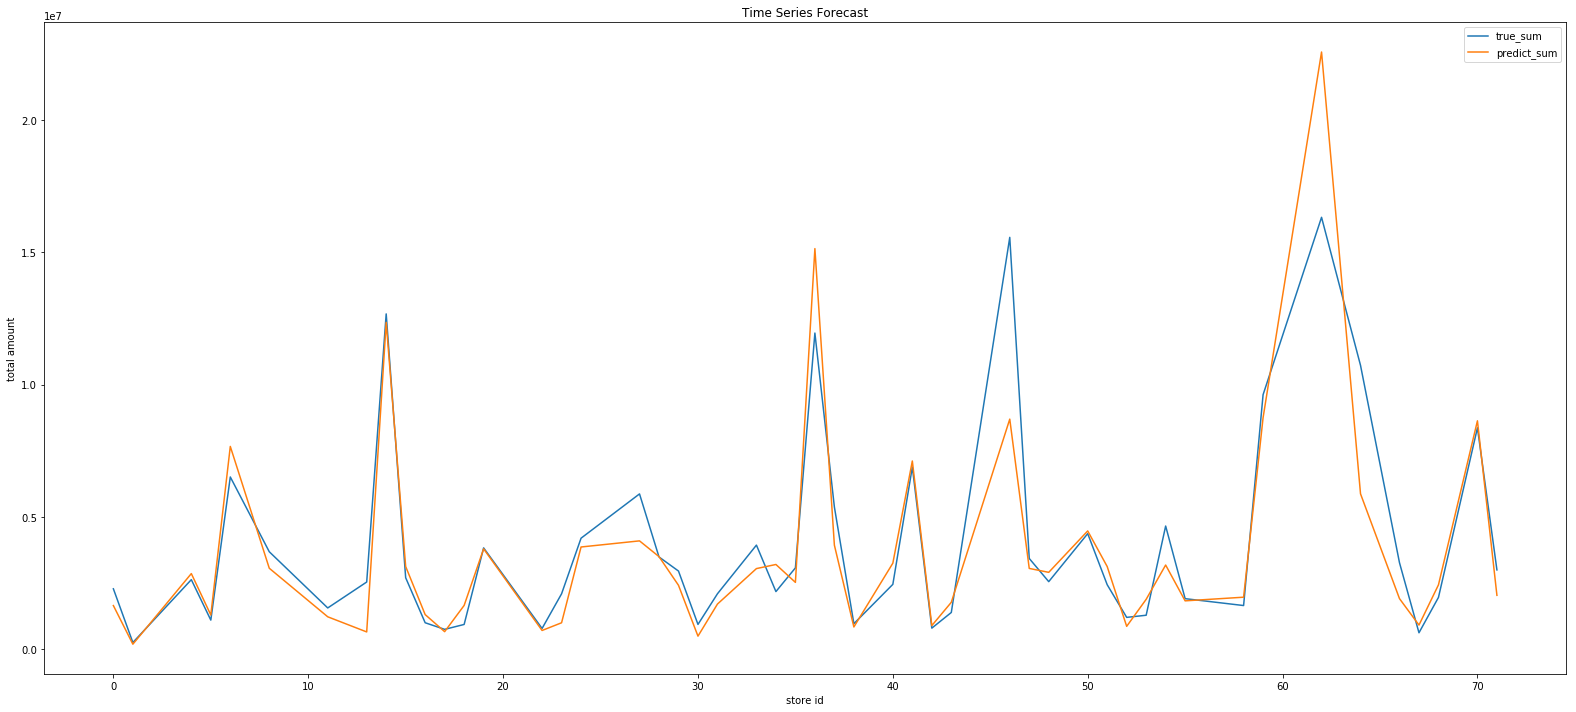

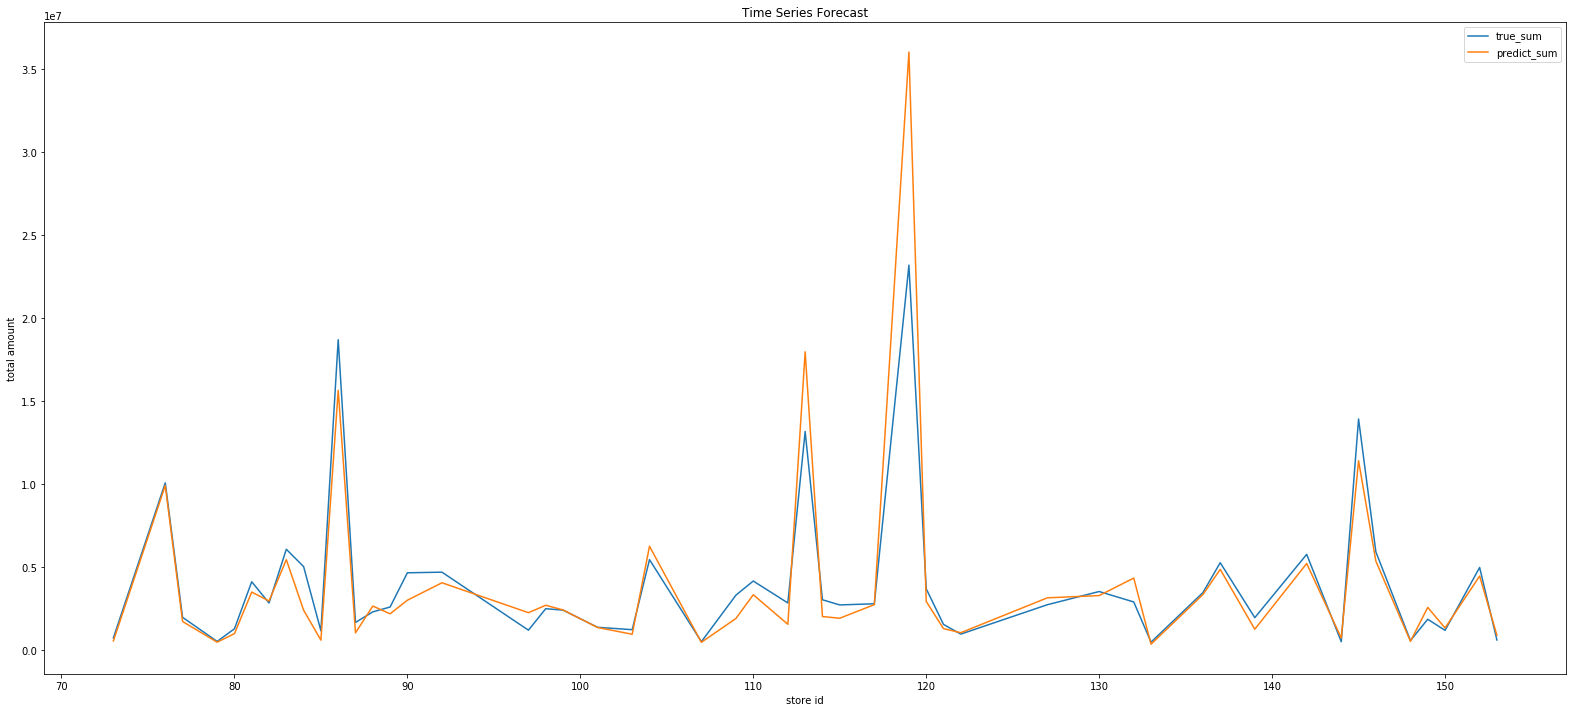

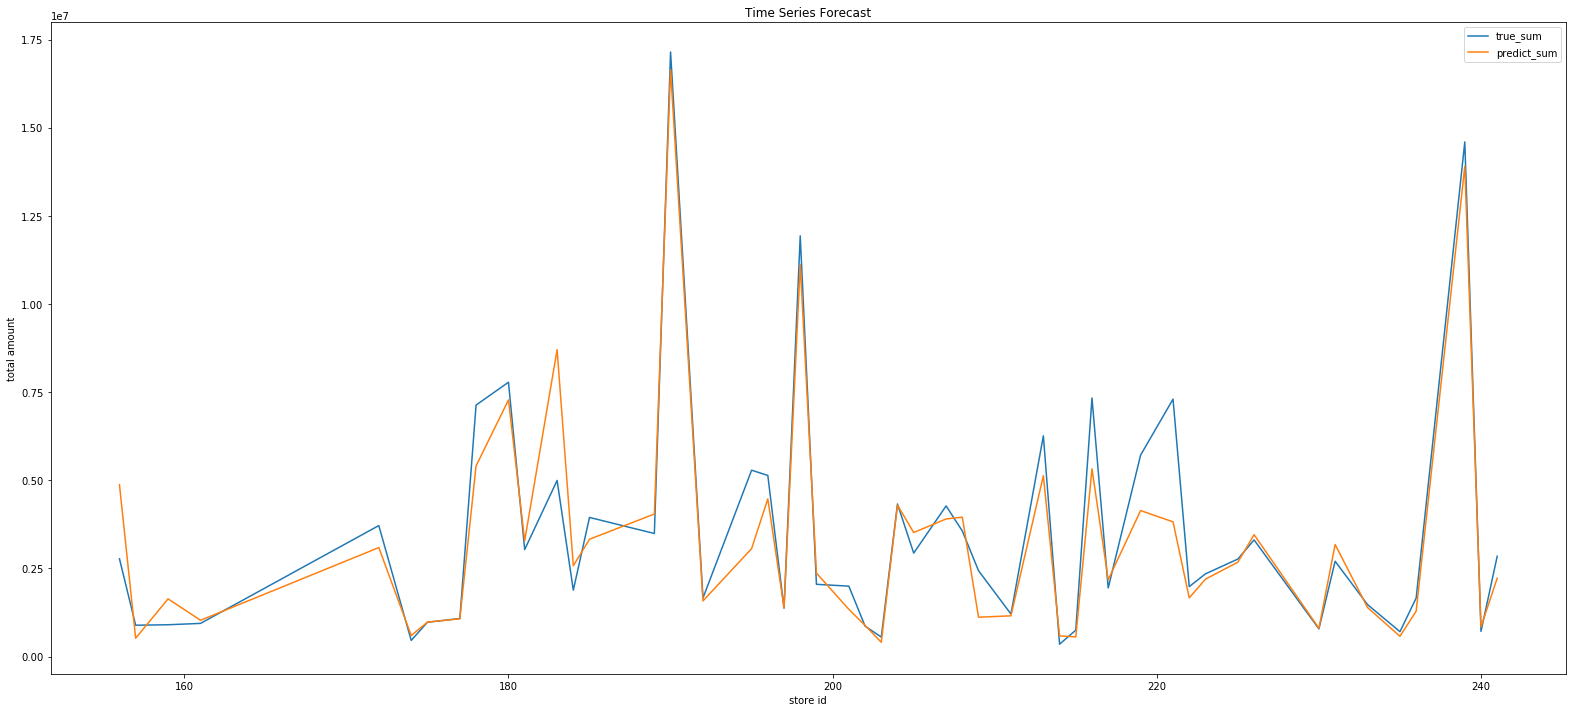

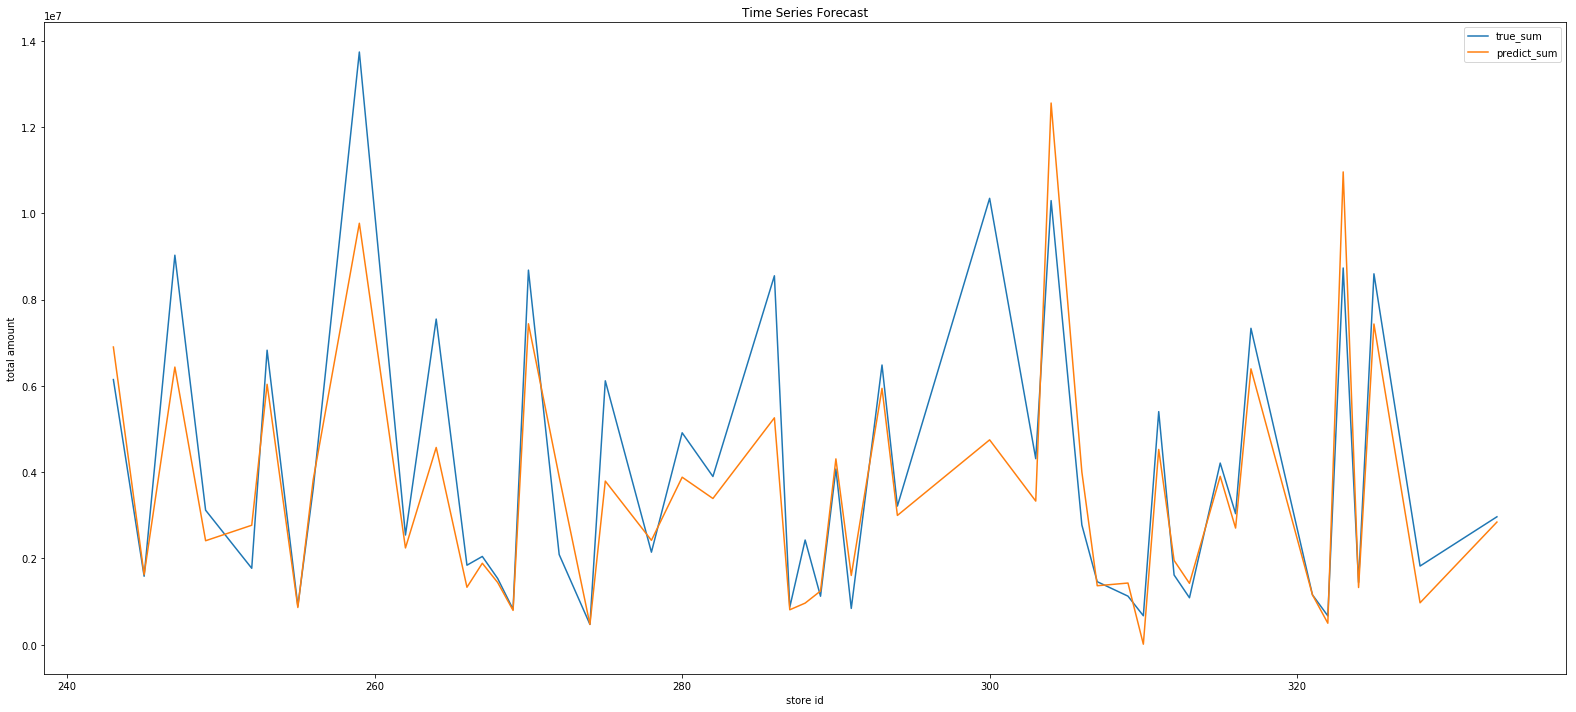

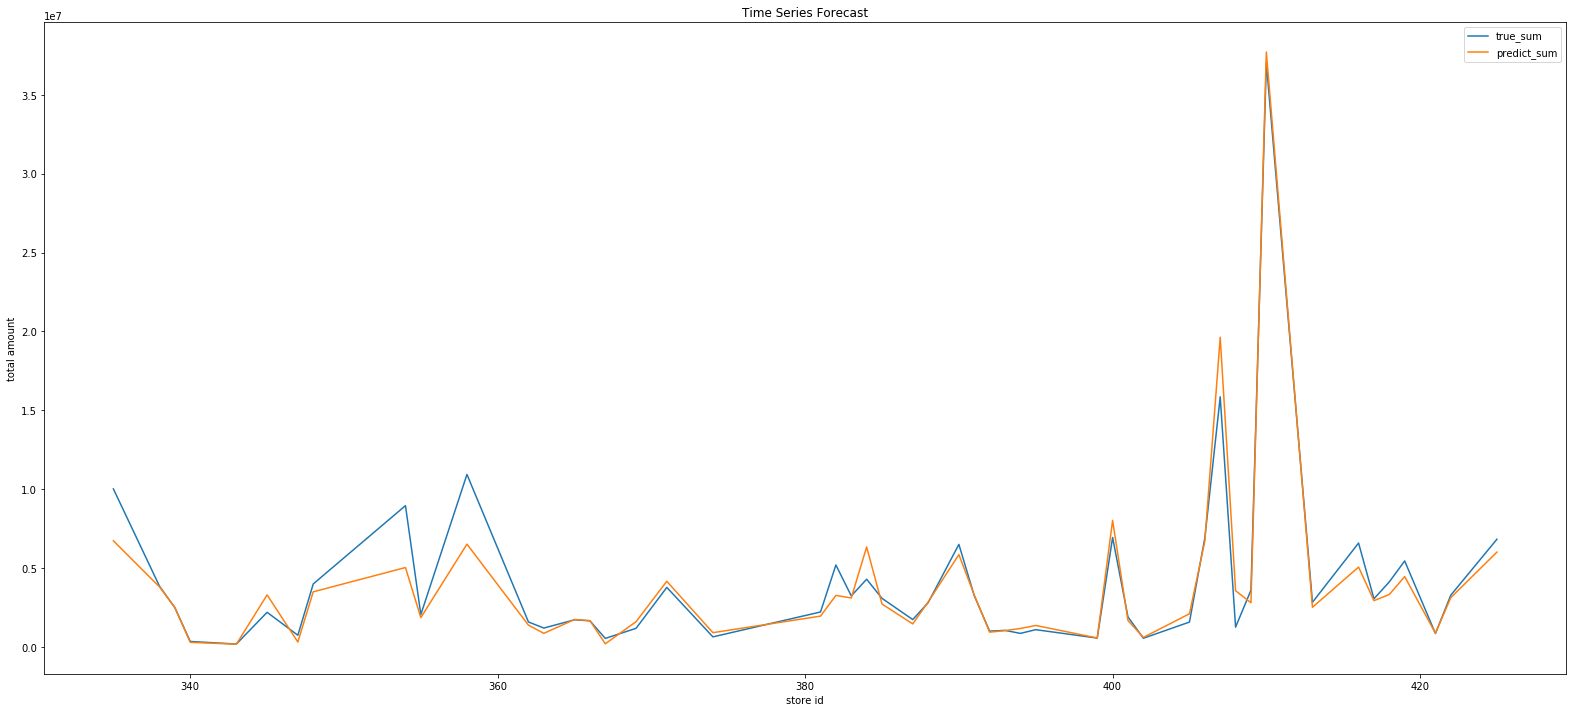

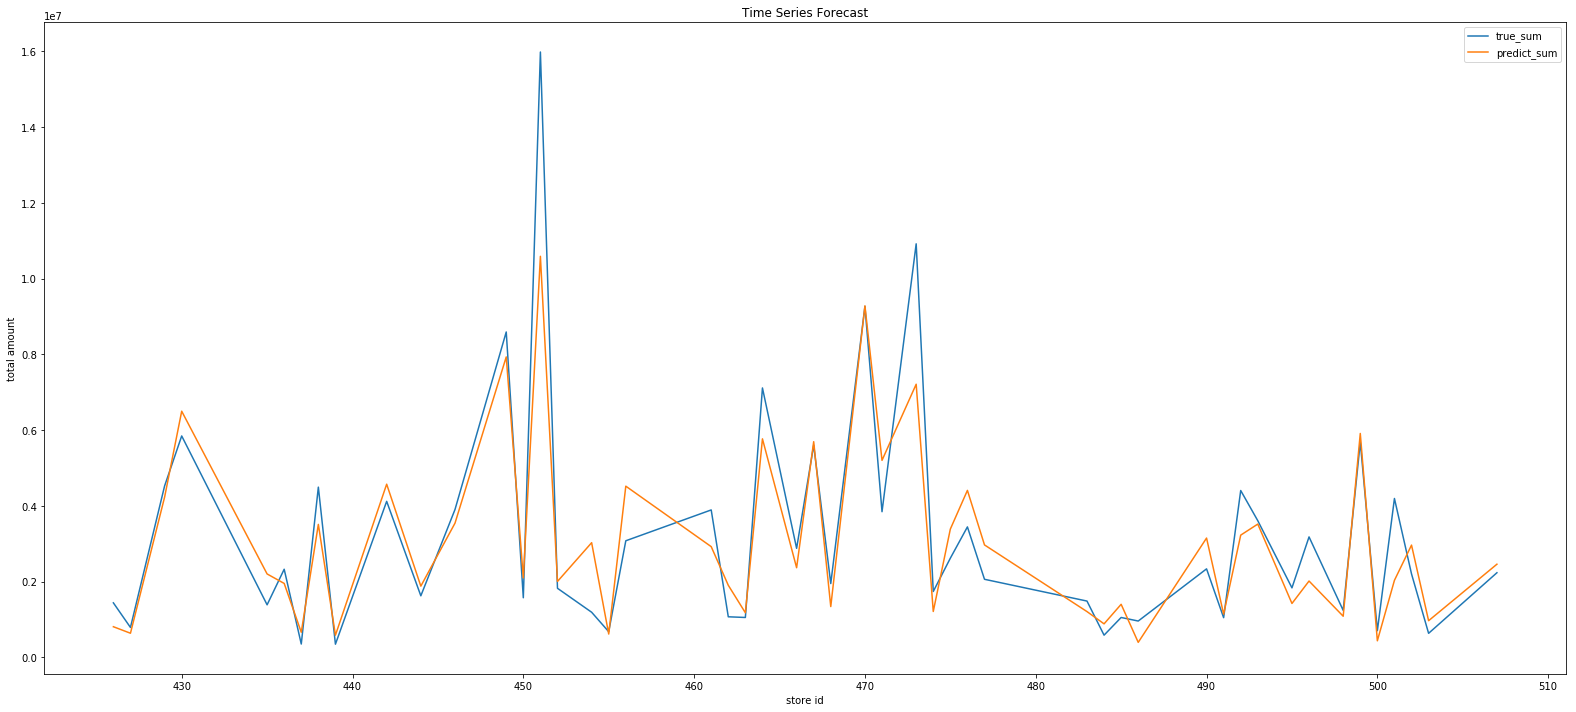

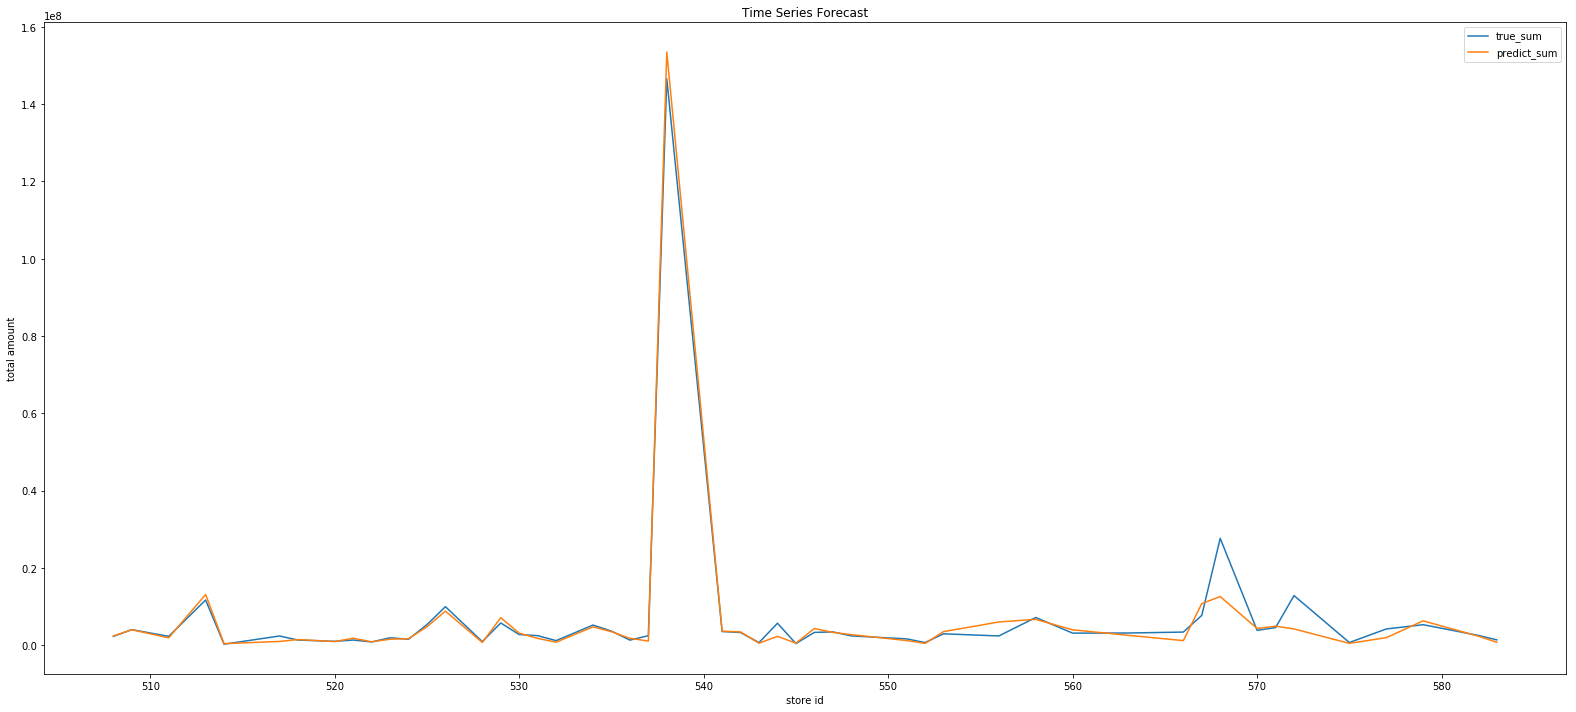

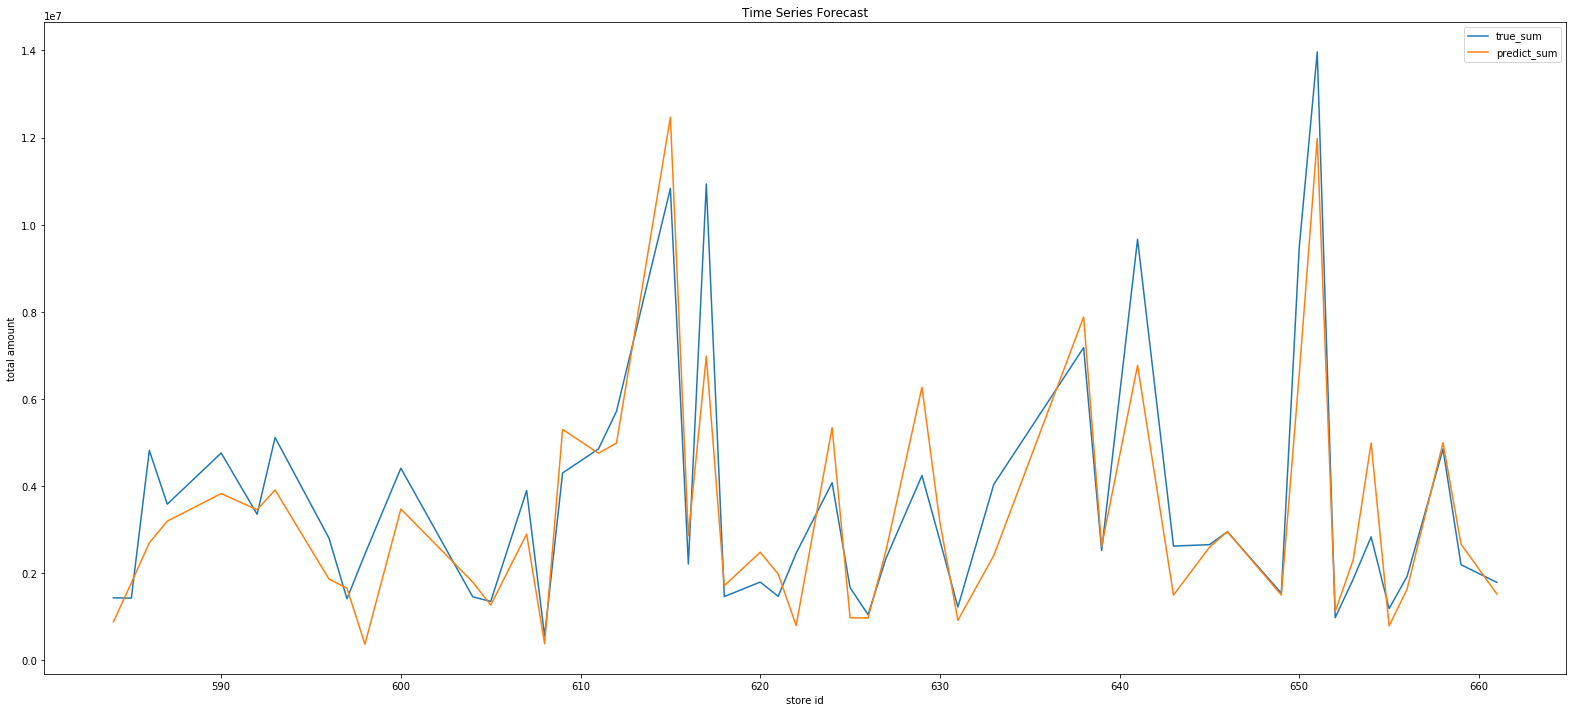

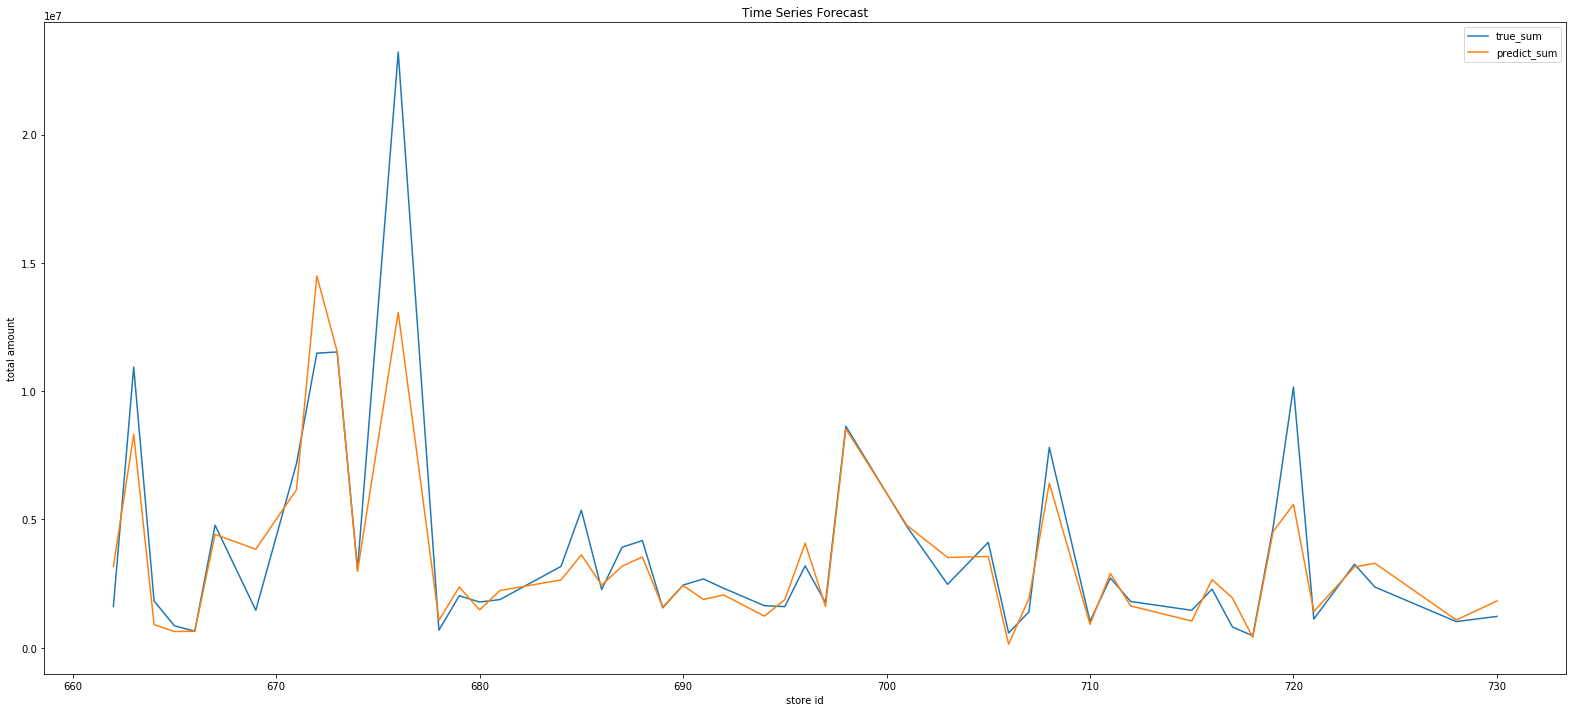

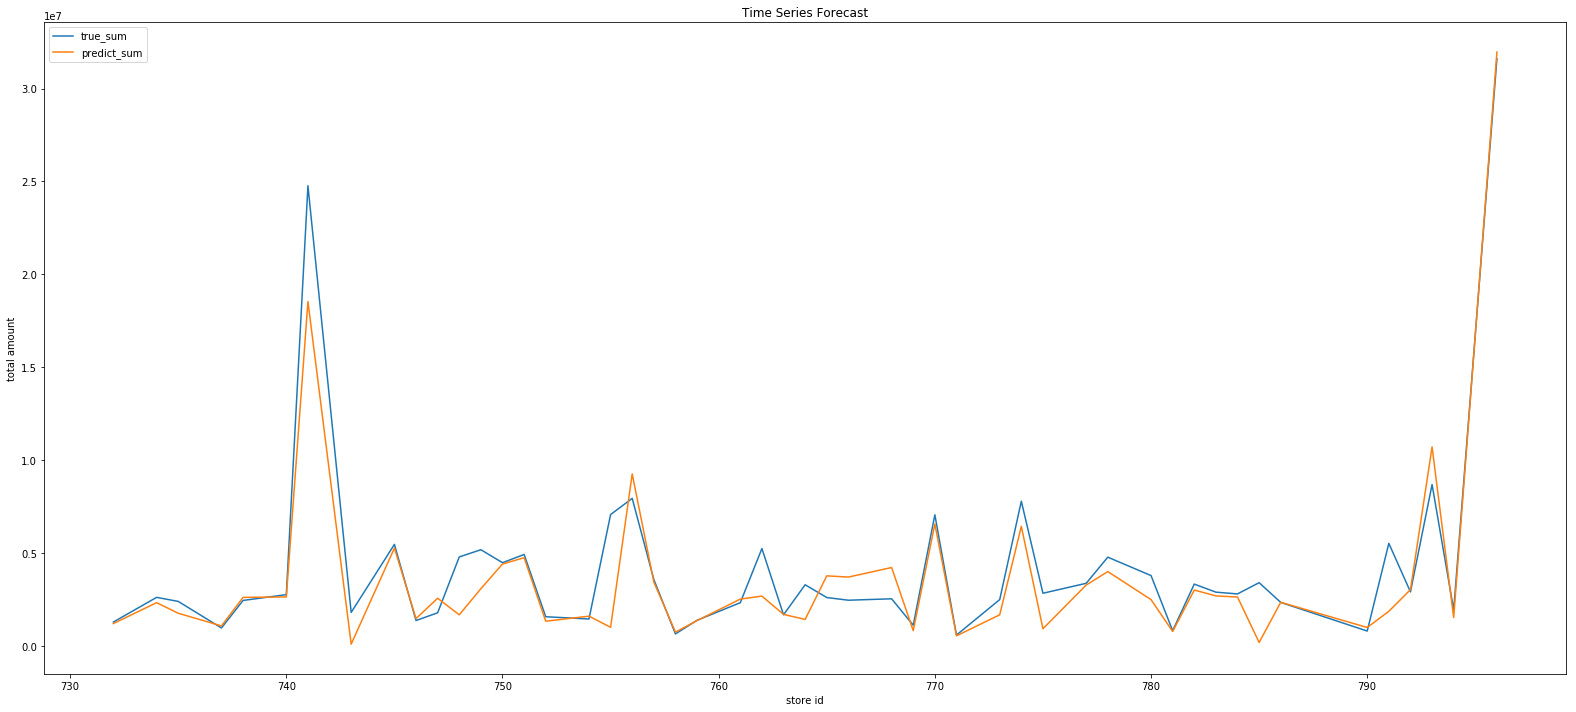

In [39]:
for i in np.arange(0,500,50):

    start = i
    end = i+ 50
    plt.figure(figsize=(22,10))
    plt.plot(true_frame[start:end],label = "true_sum")
    plt.plot(predict_frame[start:end],label = "predict_sum")
    plt.title("Time Series Forecast")
    plt.xlabel("store id")
    plt.ylabel("total amount")
    plt.legend()
    plt.tight_layout()
    plt.show()

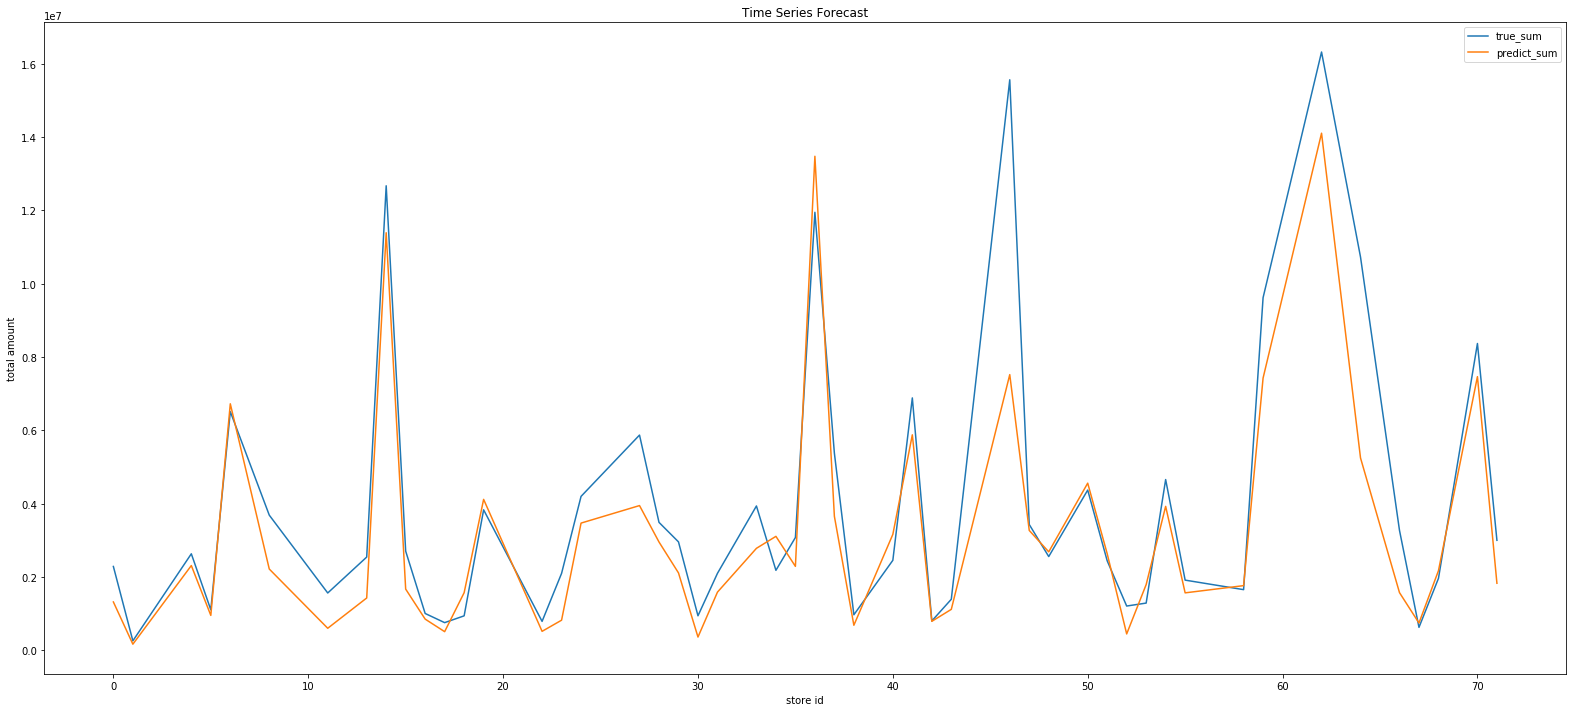

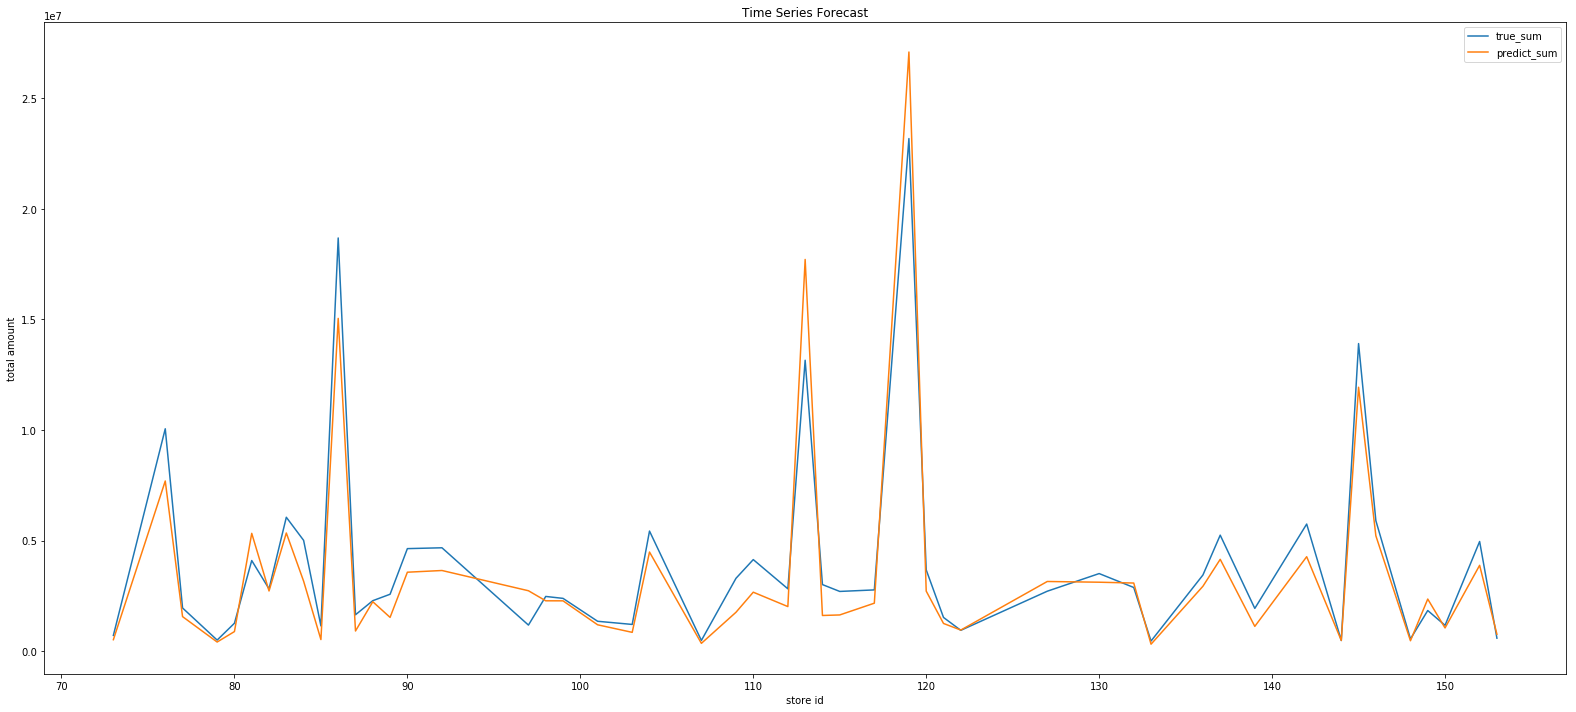

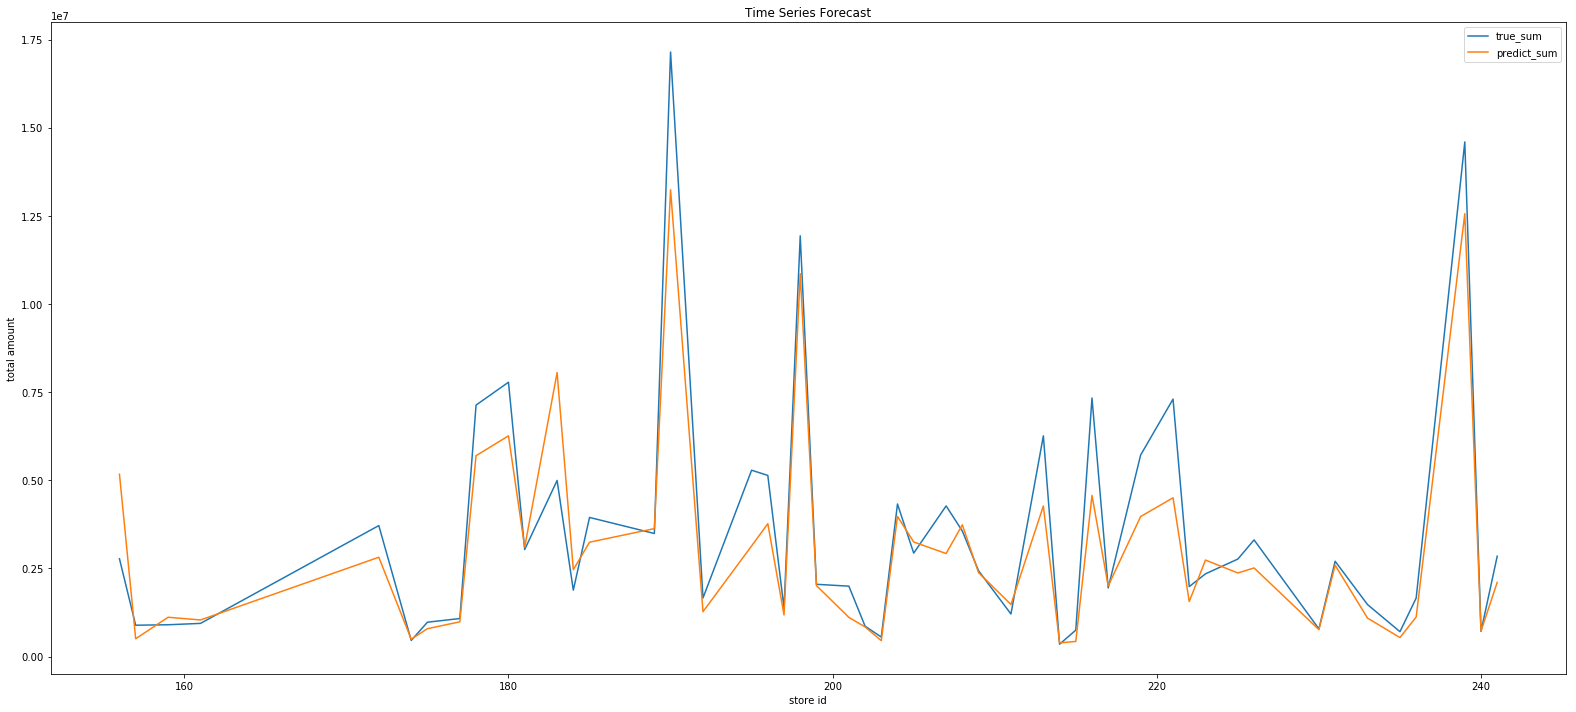

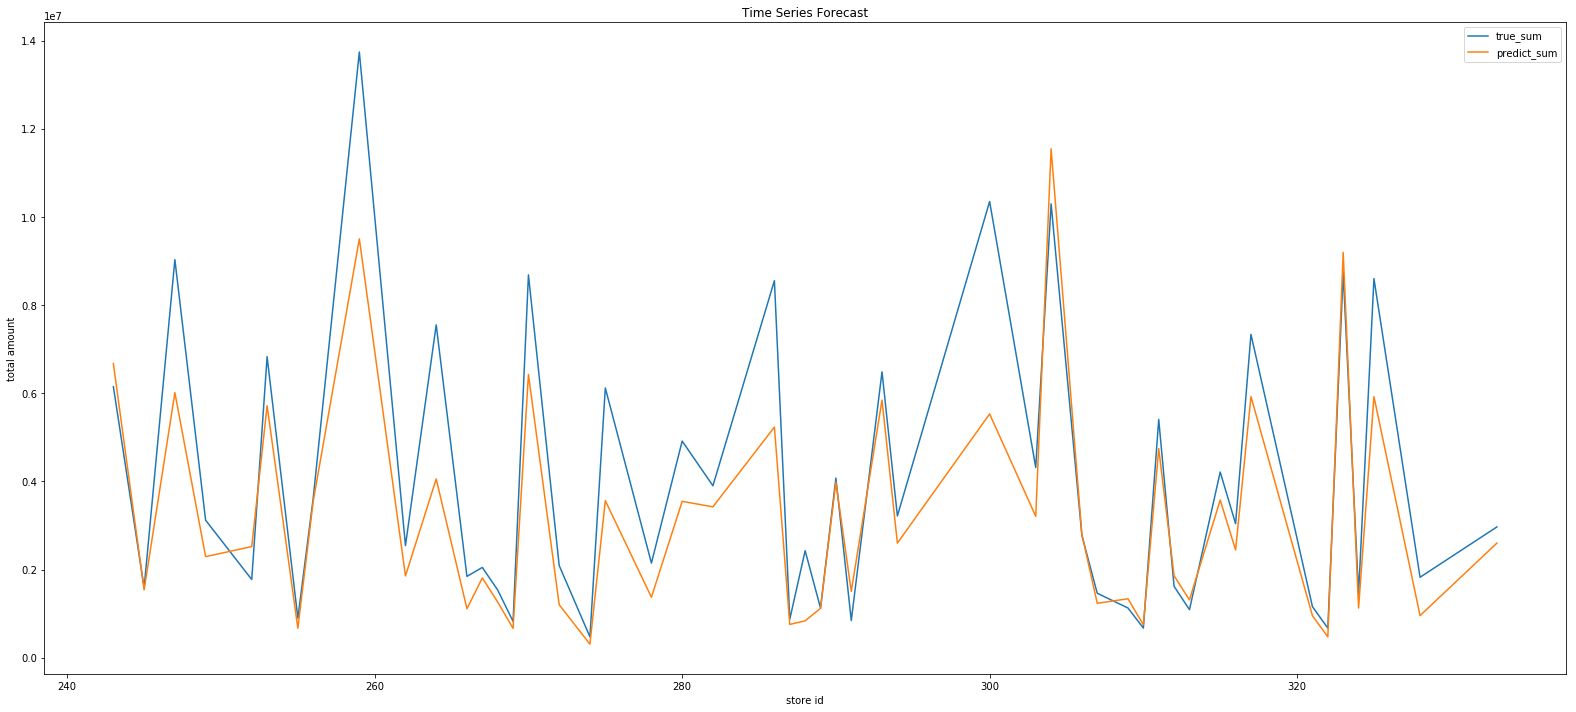

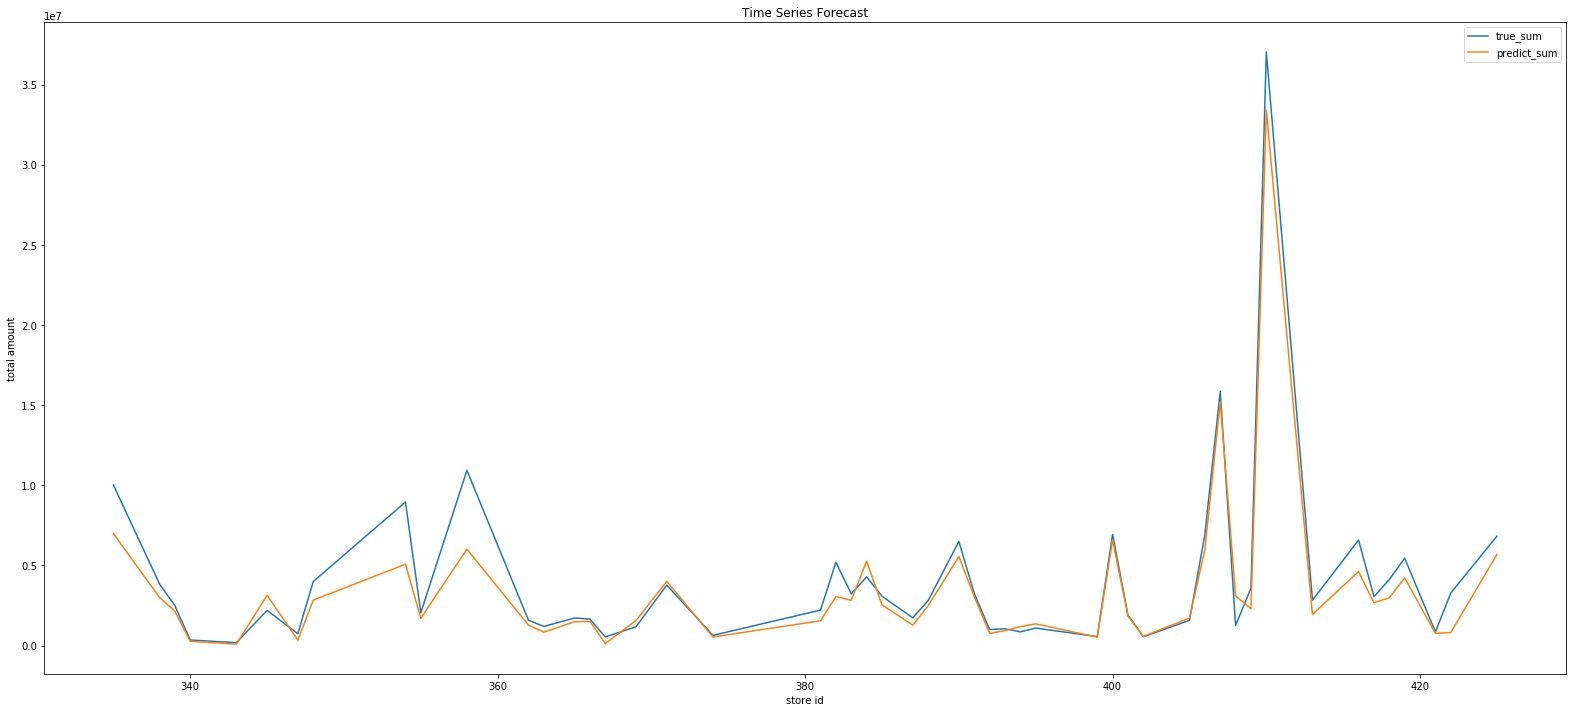

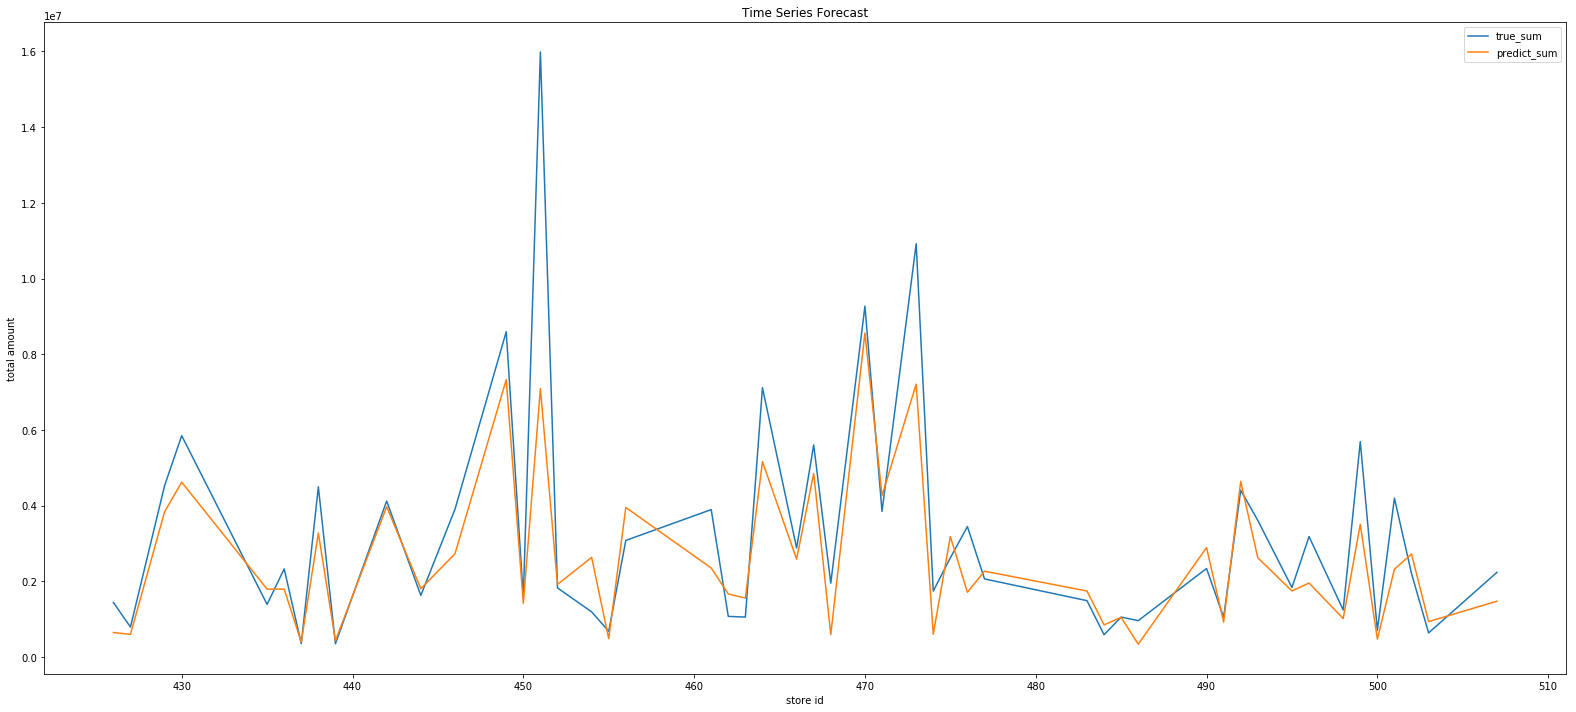

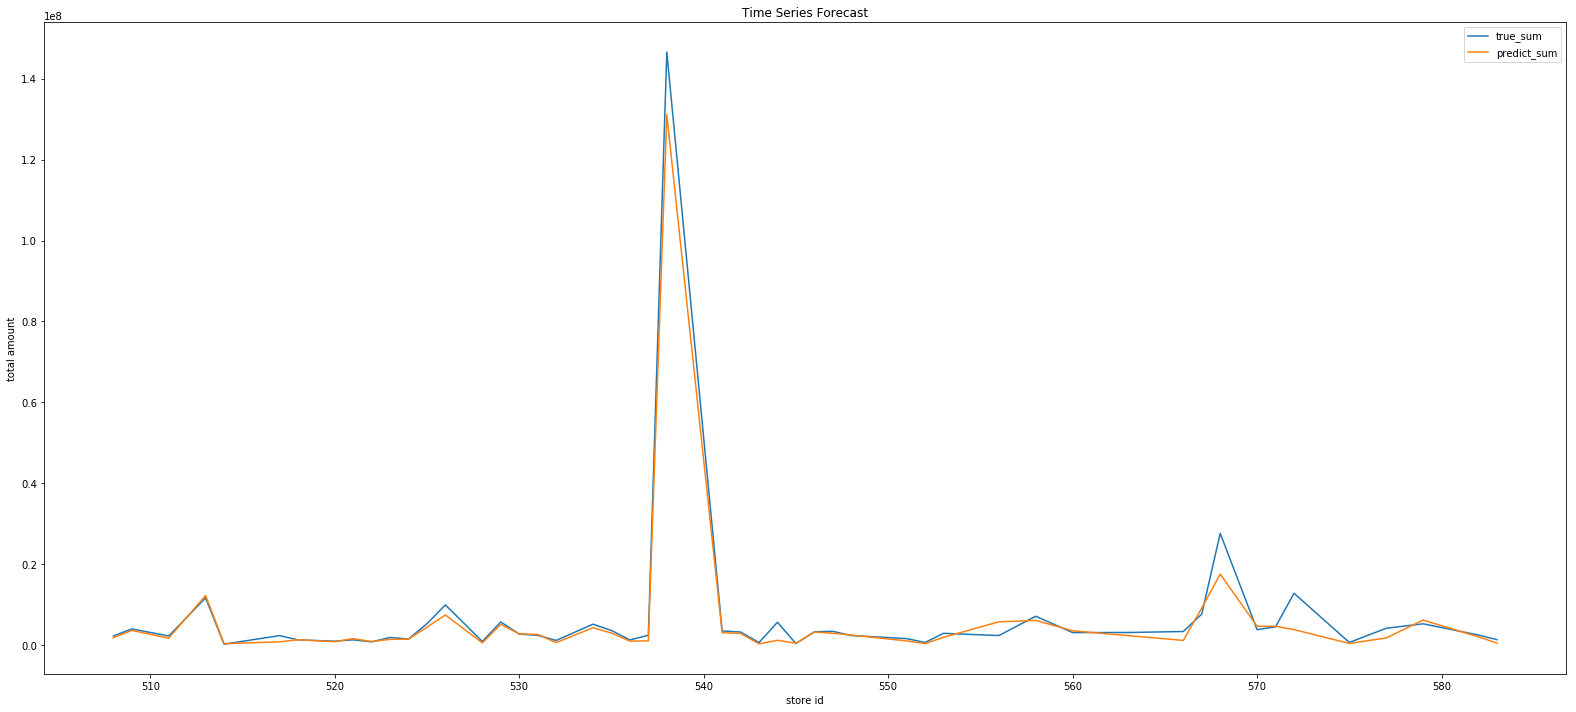

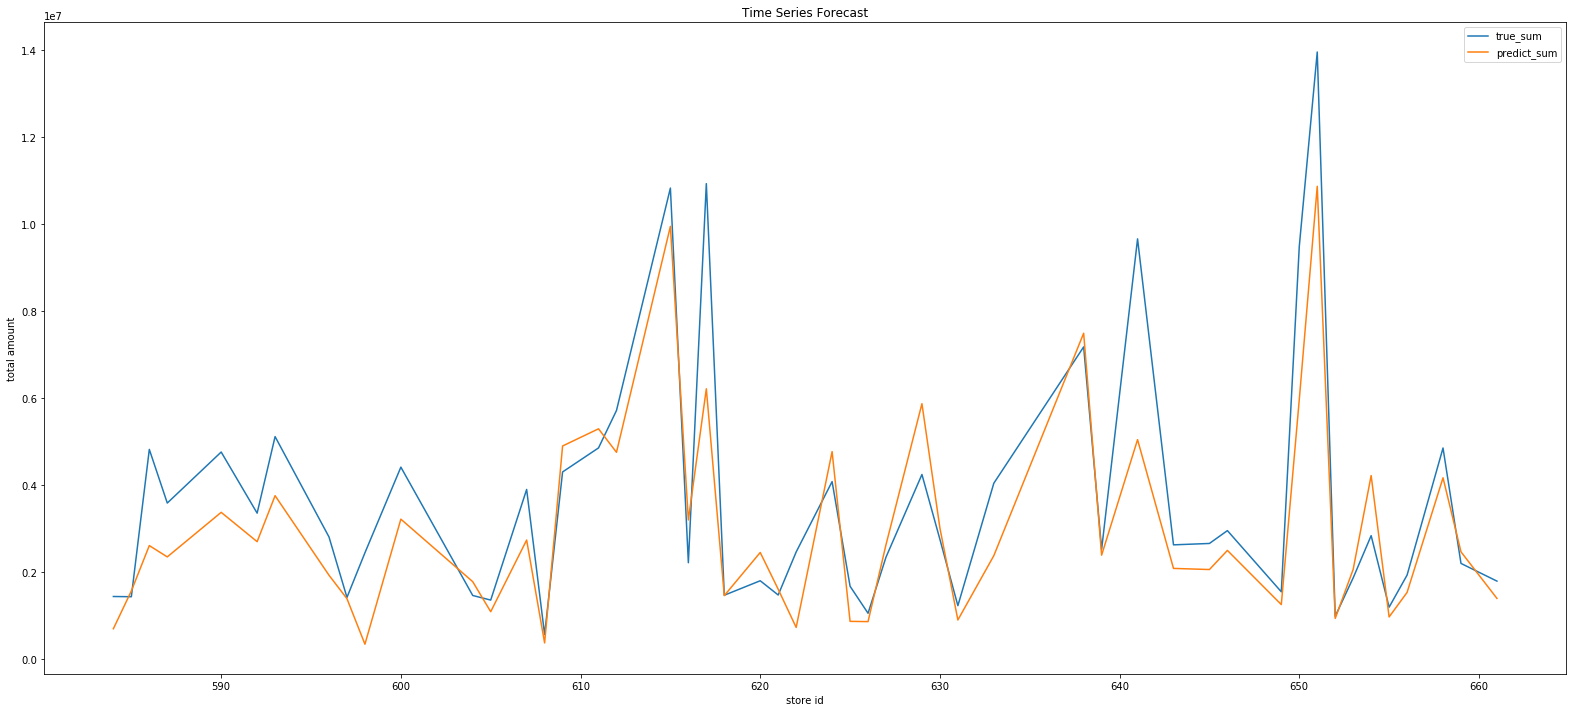

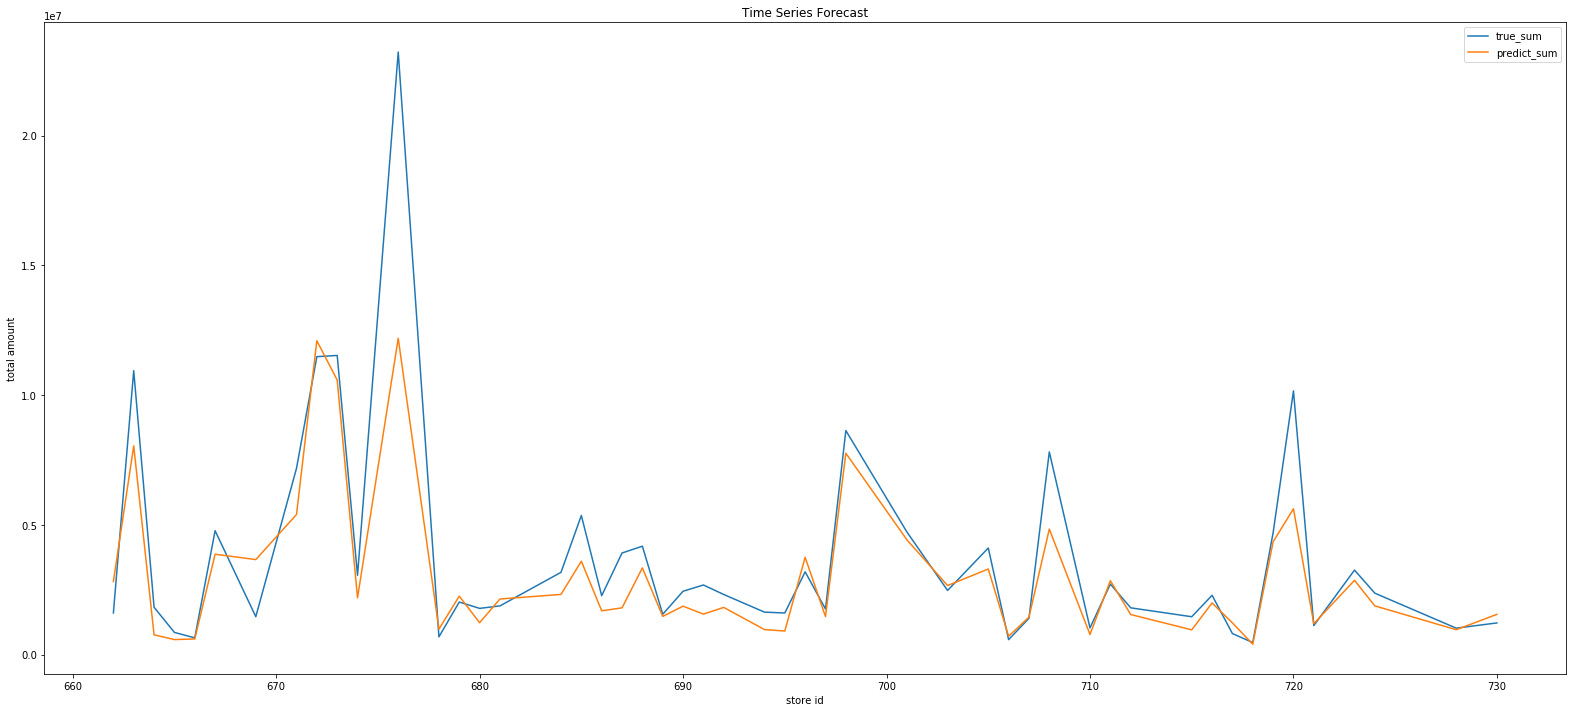

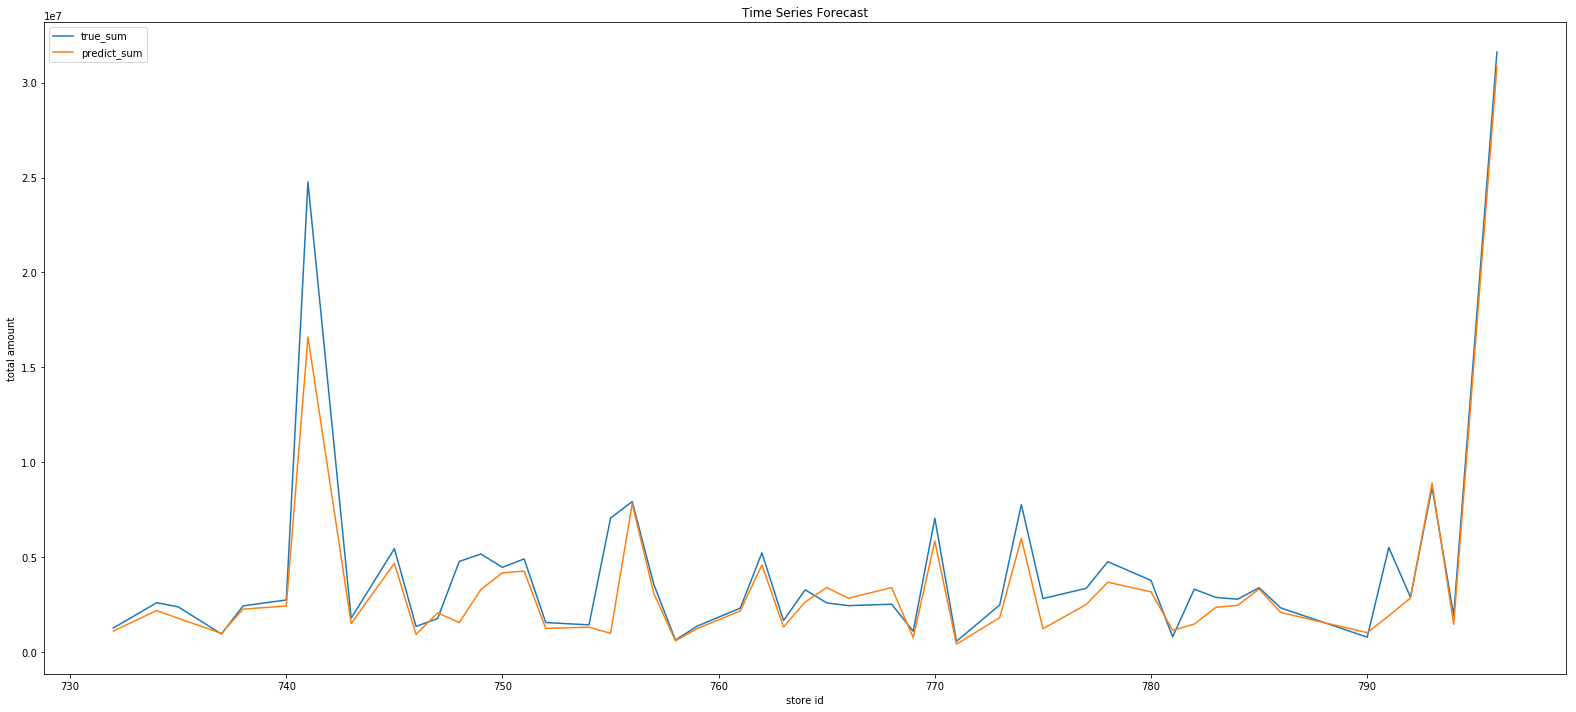

In [15]:
for i in np.arange(0,500,50):

    start = i
    end = i+ 50
    plt.figure(figsize=(22,10))
    plt.plot(true_frame[start:end],label = "true_sum")
    plt.plot(predict_frame[start:end],label = "predict_sum")
    plt.title("Time Series Forecast")
    plt.xlabel("store id")
    plt.ylabel("total amount")
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Mean Absoulute Error

In [42]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(predict_frame[:500],true_frame[:500])
print(mae)

901691.363264546
